In [32]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [33]:
num_dots = 1000

In [34]:
def generate_simple(num_dots):
    return np.random.uniform(0, 1, size=(num_dots, 2))

In [35]:
data = generate_simple(num_dots)

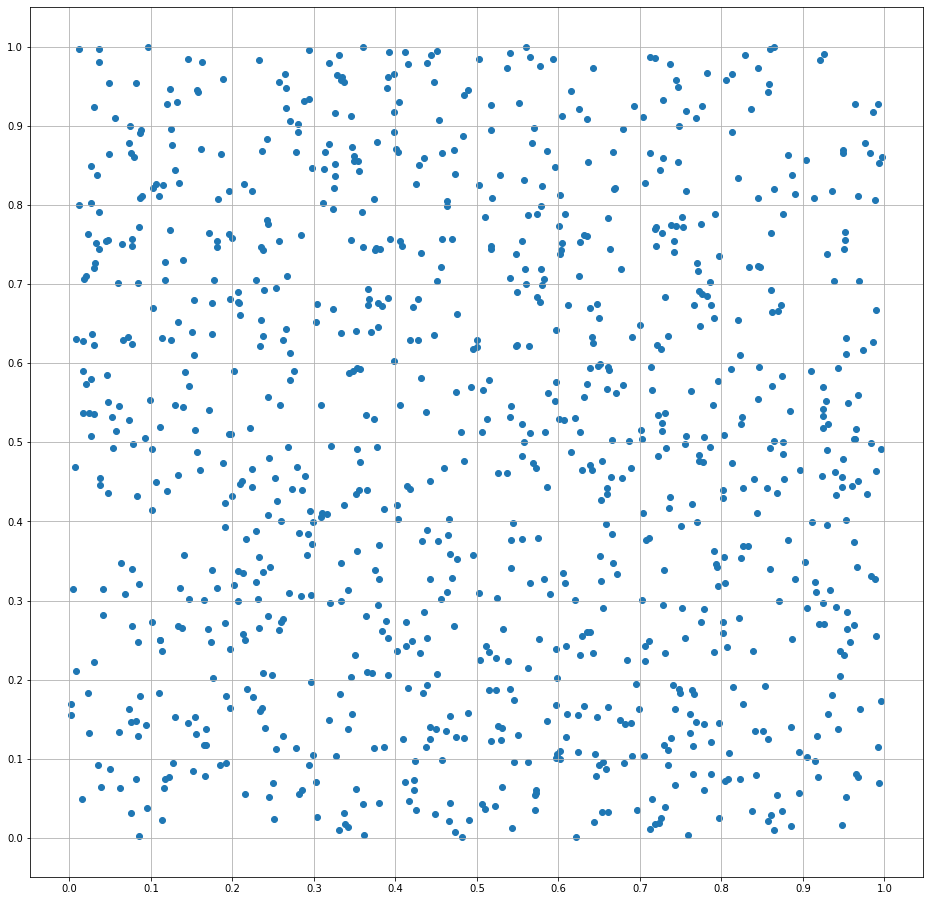

In [36]:
plt.figure(figsize=(16, 16))
plt.scatter(data[:, 0], data[:, 1])
plt.grid()
plt.yticks(ticks=np.linspace(0, 1, 11))
plt.xticks(ticks=np.linspace(0, 1, 11))
plt.show()

In [37]:
def generate_stratified(num_dots):
    data = []
    for i in range(10):
        for j in range(10):
            x = np.random.uniform(i * 0.1, (i + 1) * 0.1, size=num_dots // 100)
            y = np.random.uniform(j * 0.1, (j + 1) * 0.1, size=num_dots // 100)
            data.append(np.stack([x, y], axis=1))
    return np.concatenate(data, axis=0)

In [38]:
data = generate_stratified(num_dots)

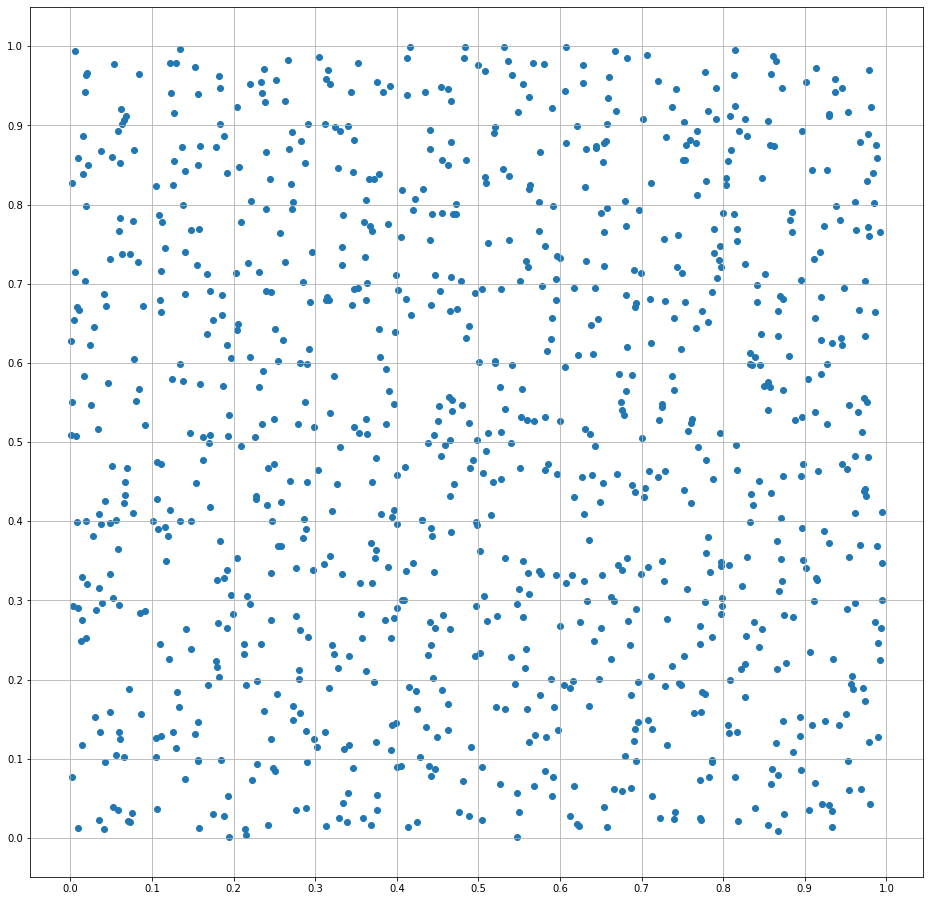

In [39]:
plt.figure(figsize=(16, 16))
plt.scatter(data[:, 0], data[:, 1])
plt.grid()
plt.yticks(ticks=np.linspace(0, 1, 11))
plt.xticks(ticks=np.linspace(0, 1, 11))
plt.show()

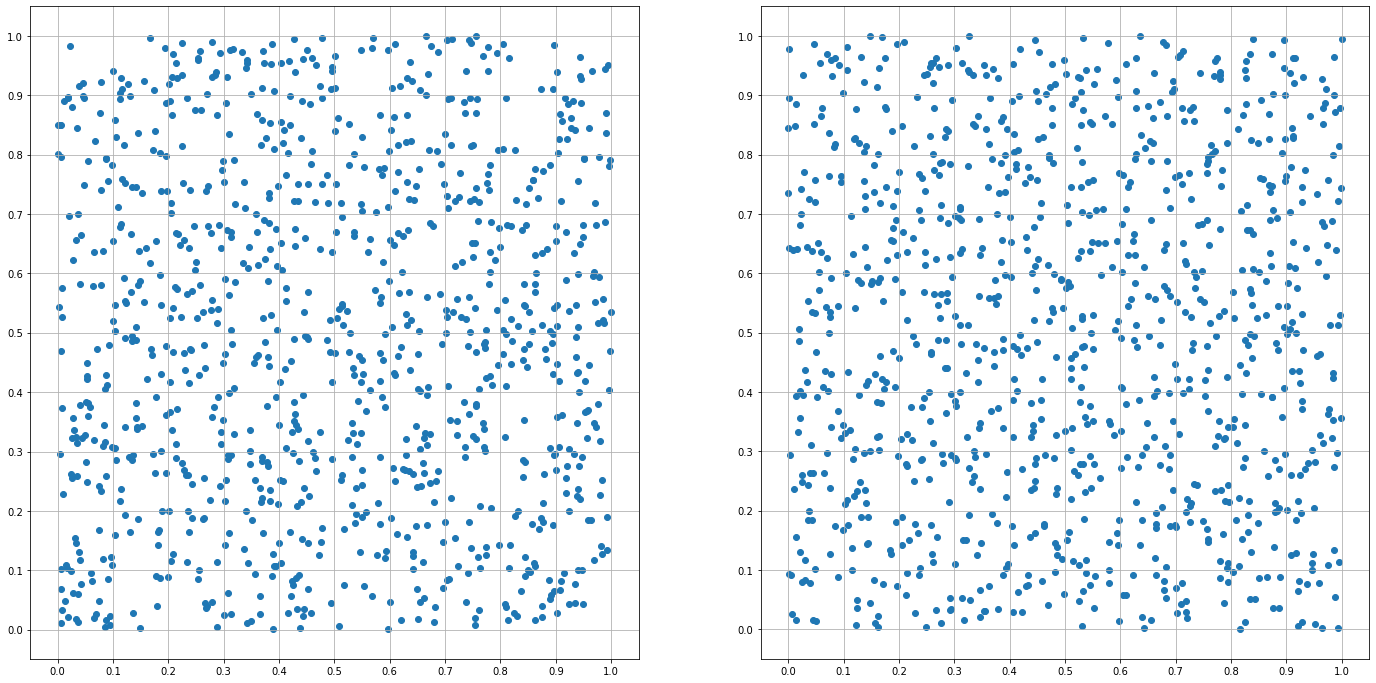

In [43]:
data_simple = generate_simple(num_dots)
data_stratified = generate_stratified(num_dots)

fig, ax = plt.subplots(figsize=(24, 12), ncols=2)
for data, a in zip([data_simple, data_stratified], ax):
    a.scatter(data[:, 0], data[:, 1])
    a.set_yticks(ticks=np.linspace(0, 1, 11))
    a.set_xticks(ticks=np.linspace(0, 1, 11))
    a.grid()
plt.show()

In [44]:
r = 0.4
true_s = np.pi * r**2 / 4

In [45]:
dist_simple = []
dist_stratified = []
for i in tqdm(range(10000)):
    data_simple = generate_simple(5000)
    data_stratified = generate_stratified(5000)
    dist_simple.append(((data_simple**2).sum(axis=1) < r**2).mean() - true_s)
    dist_stratified.append(((data_stratified**2).sum(axis=1) < r**2).mean() - true_s)

  0%|          | 0/10000 [00:00<?, ?it/s]

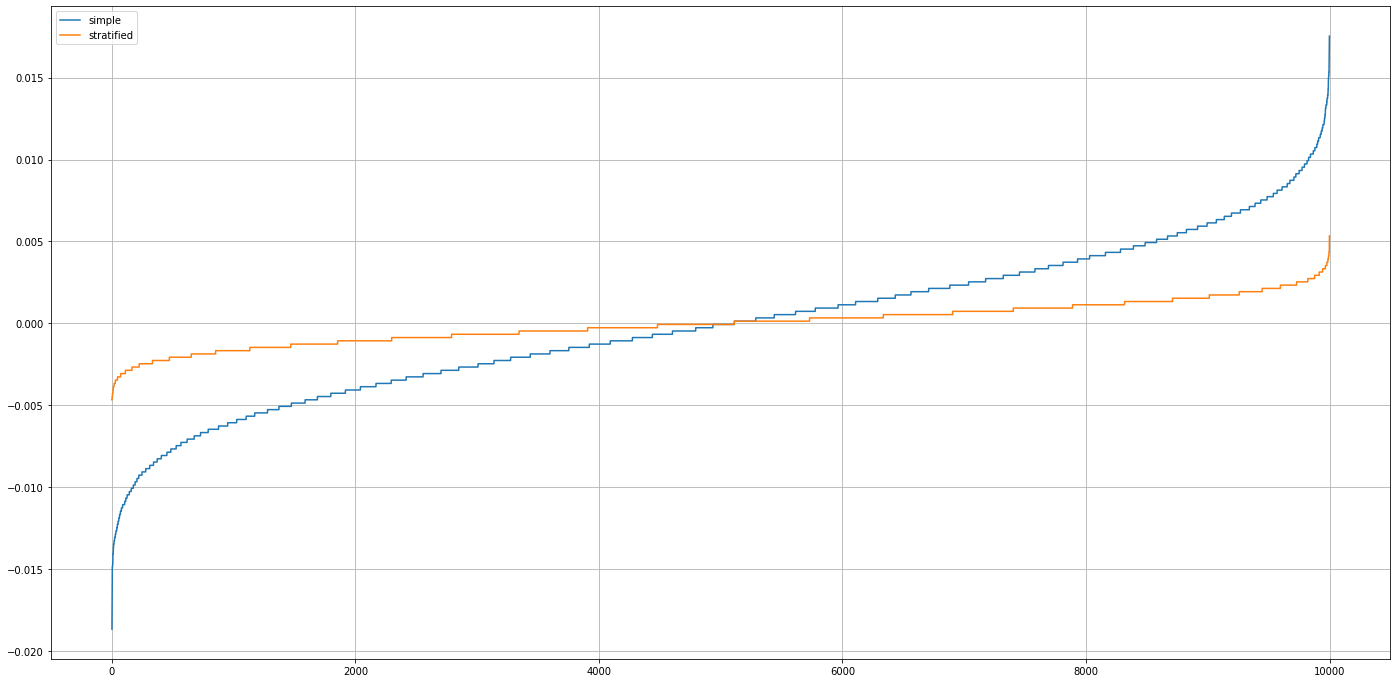

In [46]:
plt.figure(figsize=(24, 12))
plt.plot(sorted(dist_simple), label='simple')
plt.plot(sorted(dist_stratified), label='stratified')
plt.legend()
plt.grid()
plt.show()

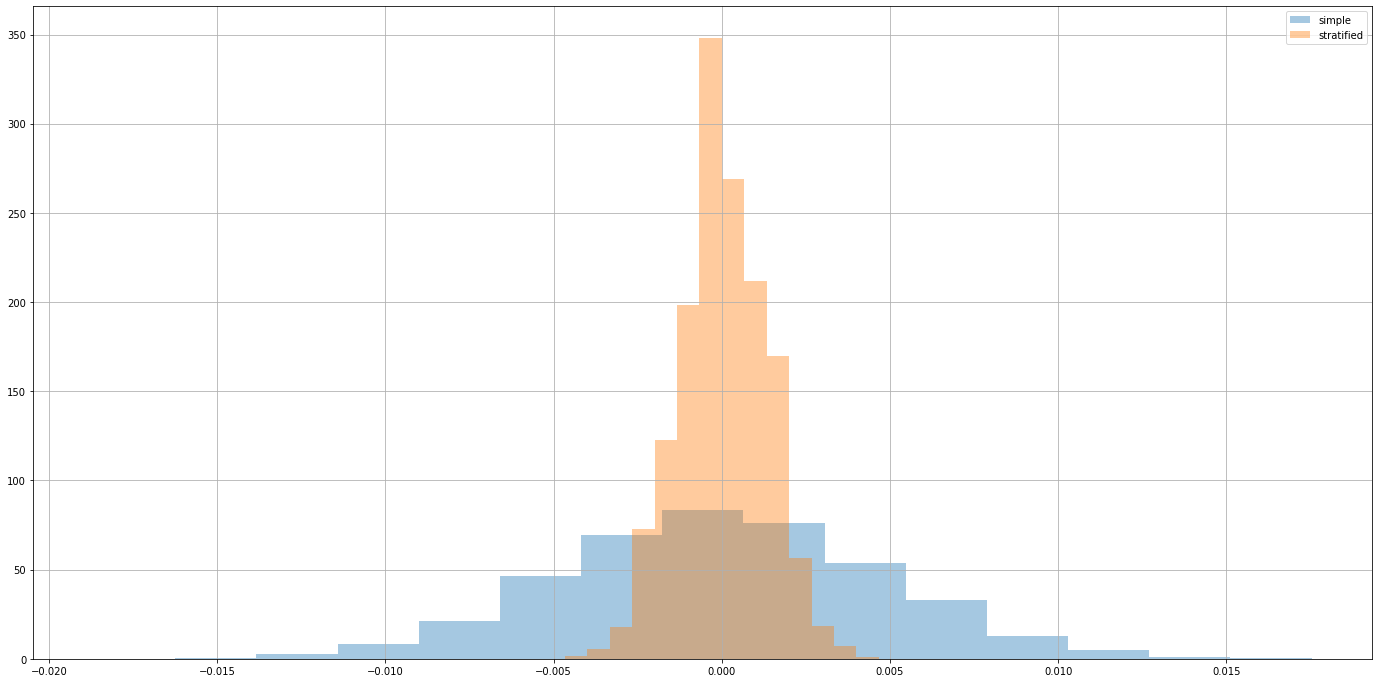

In [47]:
plt.figure(figsize=(24, 12))
plt.hist(dist_simple, alpha=0.4, density=True, bins=15, label='simple')
plt.hist(dist_stratified, alpha=0.4, density=True, bins=15, label='stratified')
plt.legend()
plt.grid()
plt.show()

In [49]:
def stratified_mean(data):
    mask_1 = (data**2).sum(axis=1) <= r**2
    mask_2 = ((data - np.asarray([0, 1]))**2).sum(axis=1) <= r**2
    mask_3 = ((data - np.asarray([1, 0]))**2).sum(axis=1) <= r**2
    mask_4 = ((data - np.asarray([1, 1]))**2).sum(axis=1) <= r**2
    return (data[mask_1].sum(axis=1).mean() + data[mask_2].sum(axis=1).mean() + data[mask_3].sum(axis=1).mean() + data[mask_4].sum(axis=1).mean()) * true_s\
            + data[~(mask_1 | mask_2 | mask_3 | mask_4)].sum(axis=1).mean() * (1 - 4 * true_s)

In [50]:
mean_simple = []
mean_stratified = []
mean_poststratified = []
for i in tqdm(range(10000)):
    data_simple = generate_simple(1000)
    data_stratified = generate_stratified(1000)
    mean_simple.append(data_simple.sum(axis=1).mean() - 1)
    mean_stratified.append(stratified_mean(data_stratified) - 1)
    mean_poststratified.append(stratified_mean(data_simple) - 1)

  0%|          | 0/10000 [00:00<?, ?it/s]

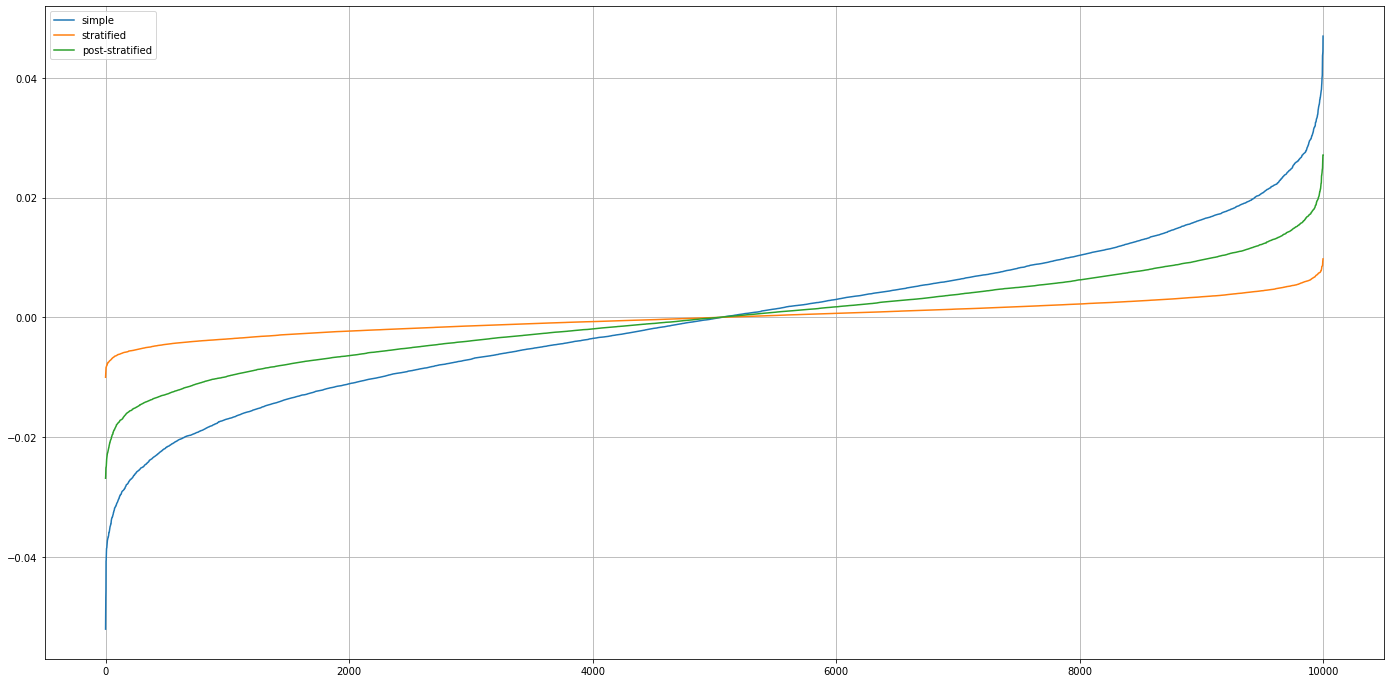

In [51]:
plt.figure(figsize=(24, 12))
plt.plot(sorted(mean_simple), label='simple')
plt.plot(sorted(mean_stratified), label='stratified')
plt.plot(sorted(mean_poststratified), label='post-stratified')
plt.legend()
plt.grid()
plt.show()

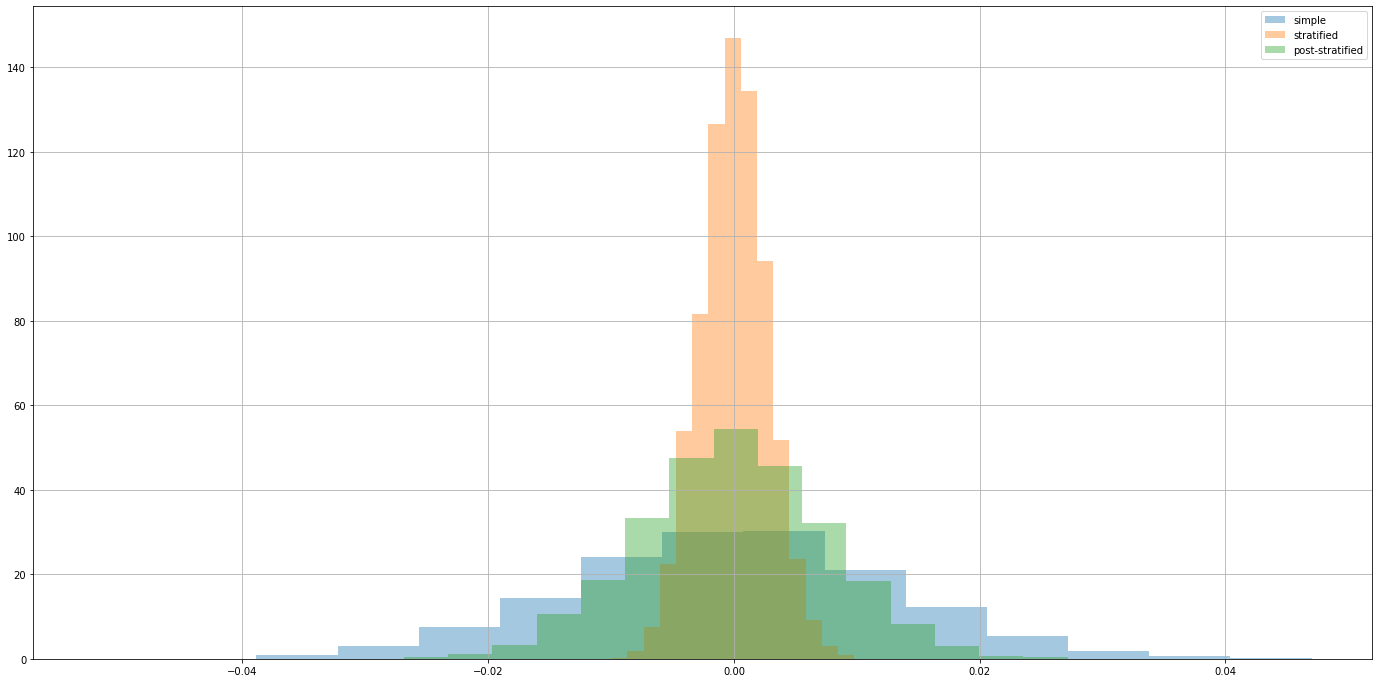

In [52]:
plt.figure(figsize=(24, 12))
plt.hist(mean_simple, alpha=0.4, density=True, bins=15, label='simple')
plt.hist(mean_stratified, alpha=0.4, density=True, bins=15, label='stratified')
plt.hist(mean_poststratified, alpha=0.4, density=True, bins=15, label='post-stratified')
plt.legend()
plt.grid()
plt.show()

In [53]:
def multivariate_normal(mu, sigma, n):
    return np.random.normal(mu, sigma, size=n)

In [54]:
x = [multivariate_normal(0, 1, 100).sum() for i in range(10000)]

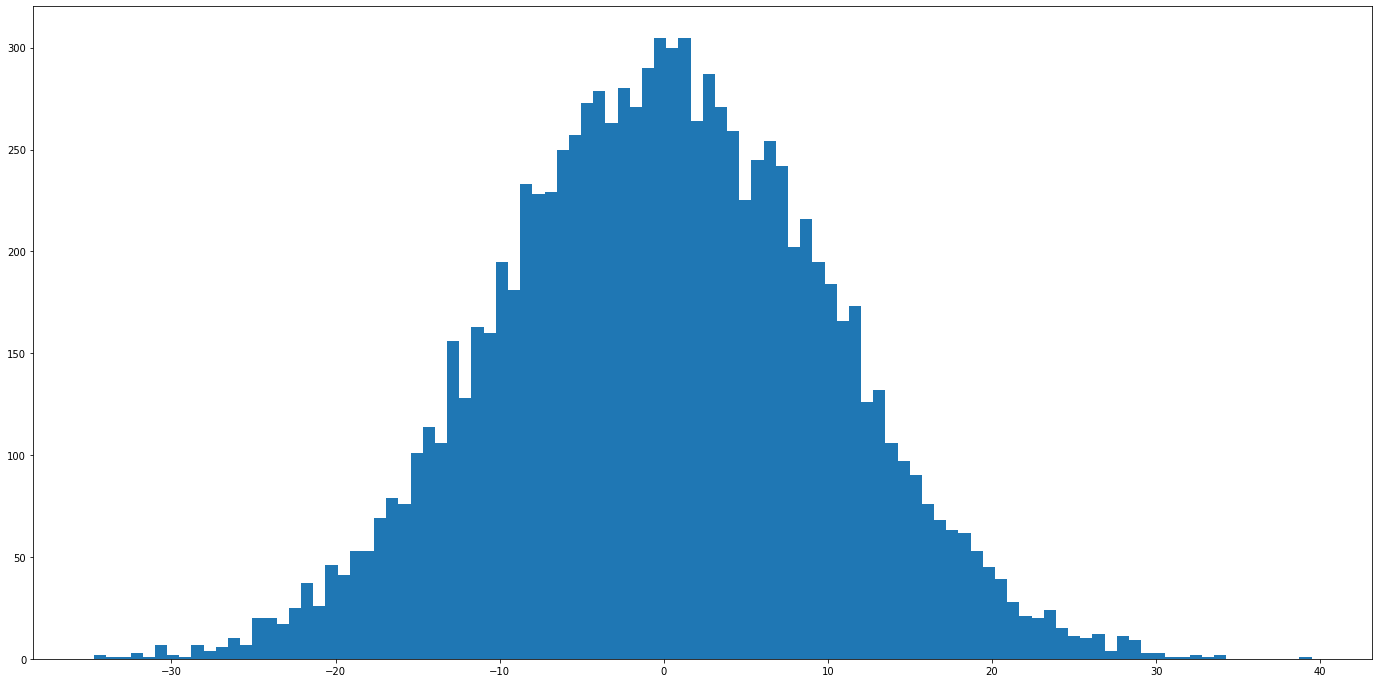

In [55]:
plt.figure(figsize=(24, 12))
plt.hist(x, bins=100)
plt.show()

In [56]:
x = [multivariate_normal(1, 1, 10).sum() for i in range(10000)]

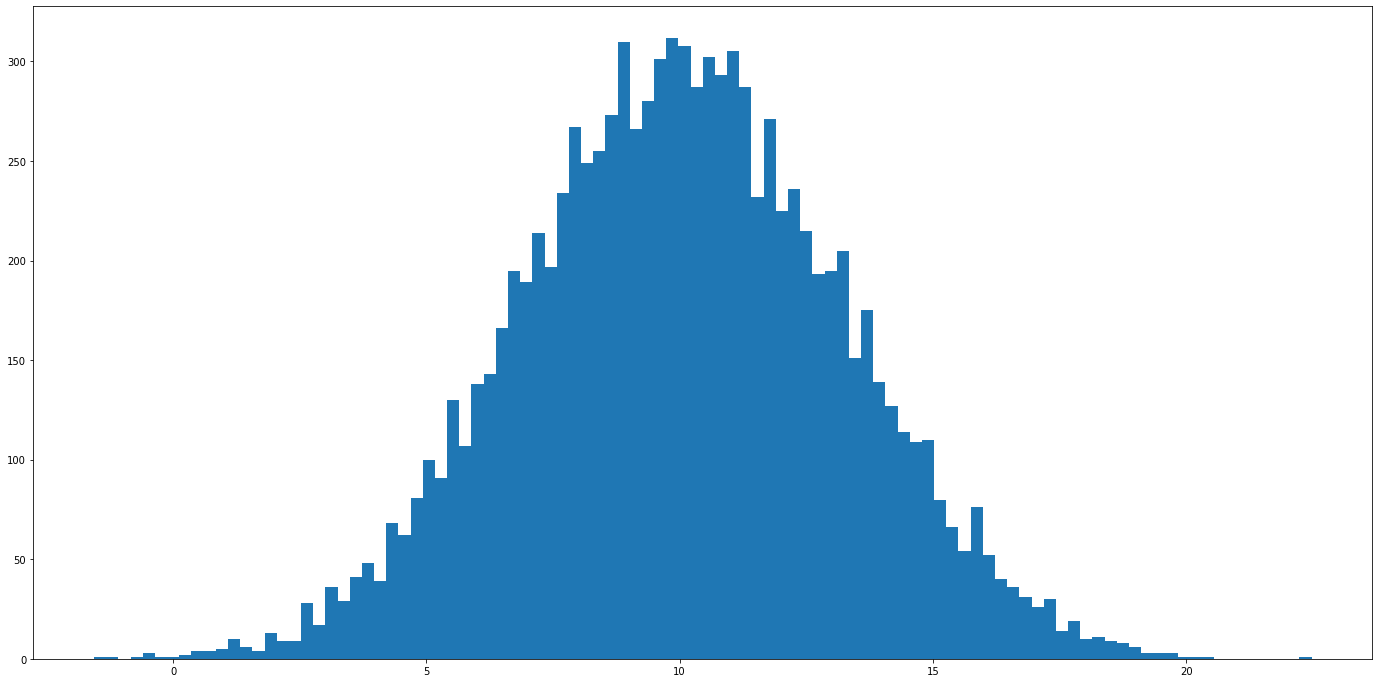

In [57]:
plt.figure(figsize=(24, 12))
plt.hist(x, bins=100)
plt.show()

In [58]:
def multivariate_mean_poststratified(n):
    data = np.random.normal(1, 1, size=n)
    thresholds = np.asarray([-np.inf] + np.arange(-2, 22, 2).tolist() + [np.inf])
    mu = 10
    sigma_sq = 10
    w = np.diff(stats.norm.cdf((thresholds - mu) / np.sqrt(sigma_sq)))
    means = np.zeros_like(w)
    counts = np.zeros_like(w)
    for i in range(2000):
        data_i = np.random.choice(data, replace=False, size=10)
        bin_ind = np.digitize(data_i.sum(), thresholds) - 1
        means[bin_ind] += data_i.mean()
        counts[bin_ind] += 1
    counts[counts == 0] = 1
    mean = (w * means / counts).sum()
    return data.mean(), mean

In [59]:
n = 100
mean_simple = []
mean_poststratified = []
for i in tqdm(range(1000)):
    simple, stratified = multivariate_mean_poststratified(n)
    mean_simple.append(simple)
    mean_poststratified.append(stratified)

  0%|          | 0/1000 [00:00<?, ?it/s]

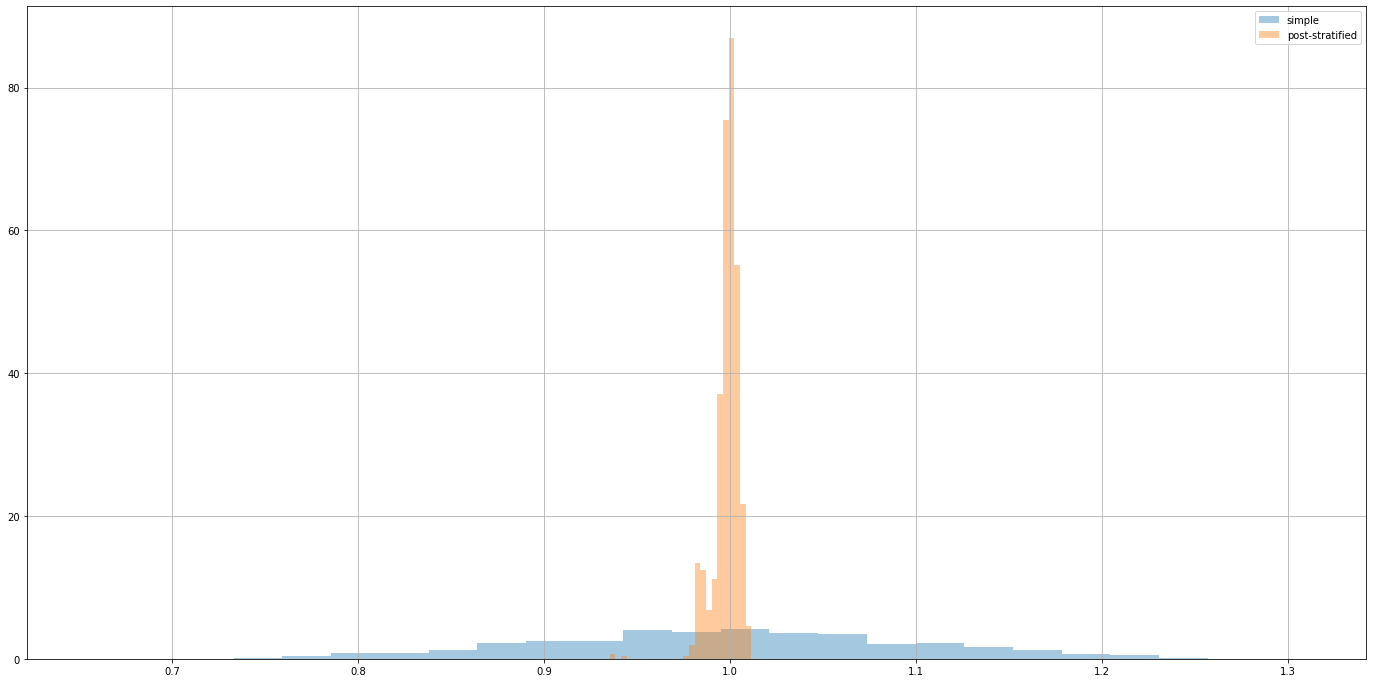

In [60]:
plt.figure(figsize=(24, 12))
plt.hist(mean_simple, alpha=0.4, density=True, bins=25, label='simple')
plt.hist(mean_poststratified, alpha=0.4, density=True, bins=25, label='post-stratified')
plt.legend()
plt.grid()
plt.show()